In [1]:
import heeps
import heeps.wavefront.qacits_vlt_package_v4 as qacits
from heeps.util.coord import mas2rms, disk_coord
from heeps.contrast.background import background
from configobj import ConfigObj
from scipy.stats import linregress
from photutils import CircularAperture, aperture_photometry
import numpy as np
import astropy.units as u
from astropy.io import fits
import os
from copy import deepcopy
import matplotlib.pyplot as plt
%matplotlib inline

# Input parameters

mags = [ 6  7  8  9 10 11]
dits = [1.e-06 1.e-02 1.e-01]
linear drift = 110 points in each direction


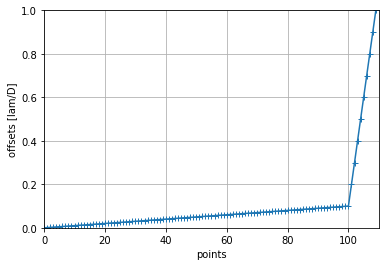

In [2]:
#os.chdir(os.path.normpath(os.path.expandvars('$HOME/CODE/Python/qacits')))
f_lyot_stop = 'ls_%s_%s_%s_%s_%s_%s.fits'
f_phase = 'wavefront/cfull/cube_Cfull_20211007_3600s_300ms_0piston_meters_scao_only_%s_%s.fits'
f_point_err = 'wavefront/point/point_all_3600s_300ms_%s.fits'
cases = ['linear_drift_only', 'scao+linear_drift', 'scao+random_drift', 'scao_only']
targets = ['point', 'alphaCen', 'pi1Gru']
qacits_model = 'optics/qacits_model_params_noinstr.ini'
# define range of magnitudes
mag_min = 6
mag_max = 11
mags = np.arange(mag_min, mag_max+1)
print('mags = %s'%mags)
# define DITs (detector integration times)
dits = np.array([1e-6, .01, .1])
print('dits = %s'%dits)
# up to 0.1 lam/D, step = 1/100
# up to 1 lam/D, step = 1/10
xy = np.append(np.arange(100)/1000, np.arange(1,11)/10)
print('linear drift = %s points in each direction'%len(xy))
plt.plot(xy,'-+')
plt.xlim(0, len(xy))
plt.ylim(0, 1)
plt.xlabel('points')
plt.ylabel('offsets [lam/D]')
plt.grid(True), plt.grid(which='minor', linestyle=':');
# qacits: number of averaged frames
n_bin           = 0 # if 0: no averaging, every estimates are returned in a 2D array
                    # if 1: average all frames before computing the estimate
                    # if n_bin=integer < n_img: will return as many estimates (frames are 
                    # averaged by bins of n_img/n_bin before computing the estimates).

In [10]:
param_file = os.path.join(conf['dir_input'], qacits_model)
ConfigObj(param_file, unrepr=True)


ConfigObj({'radii': {'inner': (0.0, 1.7), 'outer': (1.7, 2.3), 'full': (0.0, 1.7)}, 'inner_slope': 1.0, 'outer_slope': 1.0, 'full_coeff': 1.0, 'ratio': 0.0, 'phase_tolerance': 60.0, 'modul_tolerance': 0.33, 'small_tt_regime': 0.3, 'large_tt_regime': 0.2})

In [3]:
rstar_catalog = {'alphaCen': 4.26, # mas
                 'pi1Gru': 9.18, # mas
                 }
def get_fp_offsets(target, diam_ext=36.905, nr=4, disp=True):
    if target in rstar_catalog:
        rstar = rstar_catalog[target]
        fp_offsets_mas = disk_coord(rstar, nr=nr)
        fp_offsets = mas2rms(fp_offsets_mas, diam_ext)
    else:
        fp_offsets = None
    # scatter plot
    if fp_offsets is not None and disp is True:
        print('noffsets = %s'%len(fp_offsets))
        plt.scatter(fp_offsets_mas[:,0], fp_offsets_mas[:,1])
        circ = plt.Circle((0,0), rstar, linestyle=':', color='k', fill=False)
        ax = plt.gca()
        ax.add_artist(circ)
        ax.axis('equal')
        plt.xlabel('x [mas]')
        plt.ylabel('y [mas]')
        plt.title('R = %s mas (%s) - %s pts'%(rstar, target, len(fp_offsets)))
    return fp_offsets

def create_psfs(band, mode, ls_params, case, pupil_shape='', target='', verbose=False):
    # initialize conf
    dir_output = os.path.join('qacits_%s/%s_%s'%(pupil_shape, band, mode), target, case)
    conf = dict(dir_output=dir_output, band=band, mode=mode, nframes=2*len(xy),
                add_phase=True, add_point_err=True)
    if pupil_shape == 'circ':
        conf.update(f_pupil='', spi_width=0, seg_width=0, seg_gap=0)
    else:
        conf.update(f_pupil='pupil/ELT_fullM1.fits')
    conf = heeps.config.read_config(verbose=False, **conf)
    conf = heeps.config.update_config(saveconf=True, verbose=verbose, **conf)
    conf['f_phase'] = os.path.join(conf['dir_input'], f_phase%(band, conf['npupil']))
    conf['f_point_err'] = os.path.join(conf['dir_input'], f_point_err%band)
    conf['f_lyot_stop'] = os.path.join(conf['dir_input'], 'pupil', pupil_shape, f_lyot_stop%(band, mode, *ls_params, conf['npupil']))
    conf['ls_dRext'] = ls_params[0]
    conf['fp_offsets'] = get_fp_offsets(target)
    # load errors
    phase_screens, amp_screens, tiptilts, misaligns = heeps.wavefront.load_errors(verbose=verbose, **conf)
    # linear tiptilt
    diamLS = conf['diam_ext'] - conf['diam_nominal']*conf['ls_dRext']
    lamD = conf['lam']/diamLS*u.rad.to('mas')
    xy_rms = mas2rms(xy*lamD, conf['diam_ext']) # converted to mas, then to rms
    tt = np.array([(x,0) for x in xy_rms] + [(0,y) for y in xy_rms])
    # choose case
    print('\nCase = %s'%case)
    if 'linear_drift_only' in case:
        tiptilts = tt
        phase_screens = np.array([None]*conf['nframes'])
    elif 'scao_only' in case:
        tiptilts = np.array([None]*conf['nframes'])
    elif 'scao+linear_drift' in case:
        tiptilts = tt
    elif 'scao+random_drift' in case:
        pass
    # load PSFs
    try:
        psf = fits.getdata(os.path.join(conf['dir_output'], 
            'offaxis_PSF_%s_%s.fits'%(conf['band'], conf['mode'])))
        psfs = fits.getdata(os.path.join(conf['dir_output'], 
            'onaxis_PSF_%s_%s.fits'%(conf['band'], conf['mode'])))
        print('Loading "%s"'%dir_output)
    except FileNotFoundError:
        print('Simulating "%s"'%dir_output)
        # initialize wavefront
        wf = heeps.pupil.pupil(savefits=True, verbose=verbose, **conf)
        # off-axis PSF
        psf = heeps.wavefront.propagate_one(wf, onaxis=False, savefits=True, verbose=verbose, **conf)
        # on-axis PSFs
        psfs = heeps.wavefront.propagate_cube(wf, phase_screens=phase_screens, \
            amp_screens=amp_screens, tiptilts=tiptilts, misaligns=misaligns, onaxis=True, \
            savefits=True, verbose=True, **conf)
    # tiptilts in lam/D
    tt_xy = tiptilts*u.rad.to('mas')*4/conf['diam_ext']/lamD
    tt_lamD = np.sqrt(tt_xy[:,0]**2 + tt_xy[:,1]**2)
    return conf, psf, psfs, tt_lamD

def tiptilt_estimate(conf, offaxis_PSF, onaxis_PSF, tt_lamD, display=True):
    # image sampling given in pixels per lambda/D
    sampling = conf['lam']/conf['diam_ext']/(conf['pscale']*u.mas.to('rad'))
    FWHM = sampling/(1 - conf['ls_dRext'])
    # photutils aperture photometry
    n_off = offaxis_PSF.shape[-1]
    aper = CircularAperture((n_off//2, n_off//2), r=FWHM/2)
    I_off = aperture_photometry(offaxis_PSF, aper)['aperture_sum'].data
    if display==True:
        print('photutils aperture photometry: I_off=%s'%np.round(I_off,5))
    # QACITS flux estimate
    #try:
    #    I_off = qacits.get_psf_flux_v7(offaxis_PSF, 0.5, FWHM, 
    #        cyx_guess=(n_off//2, n_off//2), display=False, do_norm=False)
    #    if display==True:
    #        print('QACITS flux estimate: I_off=%s'%np.round(I_off,5))
    #except:
    #    pass
    # bin + normalize on-axis PSF cube
    onaxis_PSF_binned = qacits.bin_images(onaxis_PSF, n_bin)
    onaxis_PSF_binned /= I_off
    n_on = onaxis_PSF_binned.shape[-1]
    # tip-tilt estimate
    param_file = os.path.join(conf['dir_input'], qacits_model)
    qacits_params = ConfigObj(param_file, unrepr=True)
    tiptilt_estimate_full = qacits.quadrant_tiptilt_v7b(qacits_params, 
            onaxis_PSF_binned, (n_on//2, n_on//2), I_off[0], FWHM, 
            verbose=False, exact=True, force=None)
    # final estimator
    tiptilt_estimate = tiptilt_estimate_full[:,0:2]
    # RMS error
    diamLS = conf['diam_ext'] - conf['diam_nominal']*conf['ls_dRext']
    lamD = conf['lam']/diamLS*u.rad.to('mas')
    tt_real = tt_lamD*lamD
    tt_est = np.sqrt(tiptilt_estimate[:,0]**2 + tiptilt_estimate[:,1]**2)*lamD
    rms = np.sqrt(np.mean((tt_real - tt_est)**2))

    if display == True:
        # quadrant analysis
        img_i = -1 # last image
        subim_width_lbdd = 3
        inner_rad_lbdd  = 1.7
        outer_rad_lbdd  = 2.3
        tt_lim = 1.2
        fig1, ax1 = qacits.display_tiptilt_target(onaxis_PSF_binned[img_i], sampling, (n_on//2, n_on//2),
                                        tiptilt_estimate[img_i], subim_width_lbdd=subim_width_lbdd, 
                                        fig_num=41, tt_lim=tt_lim, plot_title='QUADRANT ANALYSIS',
                                        img_circ_rad=(inner_rad_lbdd, outer_rad_lbdd), 
                                        tt_circ_rad=(.2,.4,.6,.8,1))

        # other estimators (r, theta) -> (x,y)
        inner_rt = tiptilt_estimate_full[:,2:4] 
        inner_xy = np.vstack((inner_rt[:,0] * np.cos(inner_rt[:,1]), 
                            inner_rt[:,0] * np.sin(inner_rt[:,1]))).T
        outer_rt = tiptilt_estimate_full[:,4:6] 
        outer_xy = np.vstack((outer_rt[:,0] * np.cos(outer_rt[:,1]), 
                            outer_rt[:,0] * np.sin(outer_rt[:,1]))).T
        full_rt = tiptilt_estimate_full[:,6:8] 
        full_xy = np.vstack((full_rt[:,0] * np.cos(full_rt[:,1]), 
                            full_rt[:,0] * np.sin(full_rt[:,1]))).T
        # TT SCAN DATA: inst CALIBRATION
        colors = {'inner':[0.,0.3,.7],'outer':[.7,0.,0.3],'full':[0.,.7,0.5]}
        slopes = {}
        model_order = {'inner':1,'outer':1,'full':3}
        plt.figure(num=17, figsize=(12,9))
        fig, ax = plt.subplots(nrows=3,ncols=2,num=17)
        fig.subplots_adjust(hspace=0)
        tt_fit_lim  = {'inner': (0., 0.05),
                    'outer': (0., 0.7),
                    'full':  (0.1, 0.5)}
        ind_sort = np.argsort(tt_real)
        calib_tt = tt_real[ind_sort]
        radii = {'inner': (0.0, 1.7), 'outer': (1.7, 2.3), 'full':  (0., 2.7)}
        for i, region in enumerate(tt_fit_lim):
            ind_x = np.where((calib_tt>tt_fit_lim[region][0]) & 
                            (calib_tt<tt_fit_lim[region][1]))[0]
            x = calib_tt[ind_x]
            if   region == 'inner':
                yy  = inner_rt[ind_sort,0]
            elif region == 'outer':
                yy  = outer_rt[ind_sort,0]
            elif region == 'full':
                yy  = full_rt[ind_sort,0]
            y = yy[ind_x]
            lin_params = linregress(x,y)
            slopes[region] = lin_params.slope
        #            ax[i].set_title(region)
            ax[i,0].set_xlabel(r'True tip-tilt [$\lambda/D$]')
            ax[i,0].set_ylabel('Normalized Diff. Intensity')
            ax[i,0].plot(calib_tt, yy**model_order[region], 'o', 
                    color=colors[region], alpha=.9, markersize=2,
                    label=region+r' - r = {0:.1f} to {1:.1f} $\lambda/D$'
                    .format(radii[region][0], radii[region][1]))
            ax[i,0].plot(calib_tt, calib_tt**model_order[region]*slopes[region]**model_order[region], 
                    color=colors[region], alpha=.6, linestyle='--', 
                    label=r'Fit coeff. [{0:.2f}-{1:.2f}] $\lambda/D$ = {2:.3f}'
                    .format(tt_fit_lim[region][0],tt_fit_lim[region][1],slopes[region]**model_order[region]))
            ax[i,0].grid(color='.8',linestyle='--')
            ax[i,0].set_xlim(0.,)
        #            ax[i,0].set_ylim(0.,.0s07)
            ax[i,0].legend()
            error = ((yy**model_order[region] - 
                    calib_tt**model_order[region]*slopes[region]**model_order[region]) /
                    yy**model_order[region]) * 100.
            ax[i,1].set_xlabel(r'True tip-tilt [$\lambda/D$]')
            ax[i,1].set_ylabel('Model Error [%]')
            ax[i,1].plot(calib_tt, error, 
                    'o', markersize=2, color=colors[region], alpha=.6)
            ax[i,1].set_ylim(-20., 20.)
            ax[i,1].set_xlim(0.,)
            ax[i,1].grid(color='.8',linestyle='--')
        print('slopes ', slopes)
    return tt_real, tt_est, rms

def plot_tt_nobkg(conf, psf, psfs, tt_lamD, nframes=101):
    tt_real, tt_est, rms = tiptilt_estimate(conf, psf, psfs, tt_lamD, display=False)
    ts = np.arange(nframes)*conf['dit']
    fig, (a0, a1) = plt.subplots(2, 1, figsize=(10,6), sharex=True)
    fig.subplots_adjust(hspace=0)
    a0.plot(ts, tt_real[:nframes], label='error signal', color='k', linestyle='--')
    a0.plot(ts, tt_est[:nframes], label='QACITS estimate')
    a0.set_title('correction at %s band'%conf['band'])
    a0.set_ylabel('Pointing error (mas)')
    a0.legend(loc='upper right'); a0.grid(True)
    a0.set_xlim((0, ts[-1]))
    a0.set_ylim(bottom=0)
    error = tt_real - tt_est
    a1.plot(ts, error[:nframes], label='$\mu = %3.2f mas, \sigma = %3.2f mas$'\
                %(np.mean(error), np.std(error)))
    a1.set_xlabel('Duration (s)')
    a1.set_ylabel('Residuals (mas)')
    a1.legend(loc='upper right'); a1.grid(True)
    a1.set_xlim((0, ts[-1]))
    #plt.savefig('tt_rms.png', dpi=300, transparent=True);
    return rms

def plot_rms_mag(conf, psf, psfs, tt_lamD):
    for conf['dit'] in dits:
        print('dit = %s s, RMS = '%conf['dit'], end='')
        for conf['mag'] in mags:
            psf_ON, psf_OFF = background(deepcopy(psfs), deepcopy(psf), **conf, verbose=False)
            _,_,rms = tiptilt_estimate(conf, psf_OFF, psf_ON, tt_lamD, display=False)
            print(np.round(rms,3), end=', ')
        print('')


## Circular pupil


Case = scao+random_drift
Loading "qacits_circ/L_CVC/scao+random_drift"


0.3622969949815647

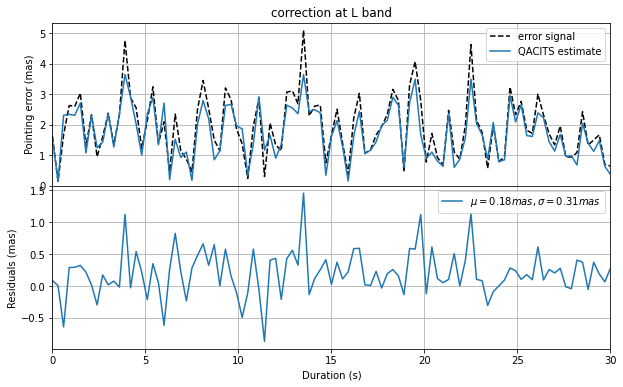

In [4]:
conf, psf, psfs, tt_lamD = create_psfs('L', 'CVC', [0.0291, 0.08, 0.0317], 'scao+random_drift', pupil_shape='circ')
plot_tt_nobkg(conf, psf, psfs, tt_lamD)

In [5]:
plot_rms_mag(conf, psf, psfs, tt_lamD)

dit = 1e-06 s, RMS = 2.014, 1.974, 1.747, 1.397, 14.734, 20.763, 
dit = 0.01 s, RMS = 2.024, 2.024, 2.024, 2.024, 2.024, 2.024, 
dit = 0.1 s, RMS = 2.024, 2.024, 2.024, 2.024, 2.024, 2.024, 


## Full M1 pupil


Case = scao+random_drift
Loading "qacits_/L_CVC/scao+random_drift"


0.6187768118939353

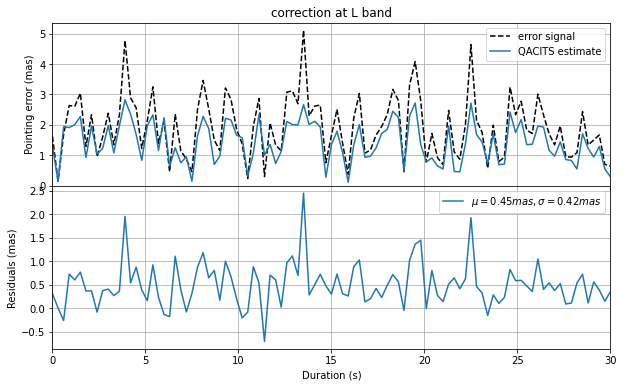

In [6]:
conf, psf, psfs, tt_lamD = create_psfs('L', 'CVC', [0.0291, 0.08, 0.0317], 'scao+random_drift')
plot_tt_nobkg(conf, psf, psfs, tt_lamD)


In [7]:
plot_rms_mag(conf, psf, psfs, tt_lamD)

dit = 1e-06 s, RMS = 2.01, 1.944, 1.575, 3.443, 18.231, 20.913, 
dit = 0.01 s, RMS = 2.024, 2.024, 2.024, 2.024, 2.024, 2.024, 
dit = 0.1 s, RMS = 2.024, 2.024, 2.024, 2.024, 2.024, 2.024, 



Case = scao+random_drift
Loading "qacits_/N2_CVC/scao+random_drift"


2.160608266515856

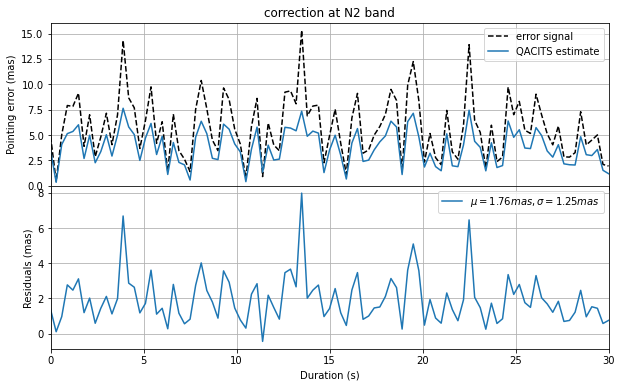

In [8]:
conf, psf, psfs, tt_lamD = create_psfs('N2','CVC', [0.0356, 0.08,  0.0383], 'scao+random_drift')
plot_tt_nobkg(conf, psf, psfs, tt_lamD)

In [9]:
plot_rms_mag(conf, psf, psfs, tt_lamD)

dit = 1e-06 s, RMS = 21.417, 59.59, 61.516, 60.499, 60.499, 60.499, 
dit = 0.01 s, RMS = 6.071, 6.071, 6.07, 6.067, 6.048, 5.926, 
dit = 0.1 s, RMS = 6.071, 6.071, 6.071, 6.071, 6.07, 6.066, 
